In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', None)

In [2]:
#data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
#!wget $data

df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### 1. Data Prep

In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [4]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
for i in numerical:
    df[numerical] = df[numerical].fillna(0.0)

for i in categorical:
    df[categorical] = df[categorical].fillna('NA')

In [7]:
from sklearn.model_selection import train_test_split

In [59]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_full_train), len(df_train), len(df_test), len(df_val)

(1169, 876, 293, 293)

In [60]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [61]:
y_full_train = df_full_train['converted'].values
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

In [62]:
# del df_full_train['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1
### R: number_of_courses_viewed 

In [12]:
from sklearn.metrics import auc, roc_auc_score

In [33]:
for i in numerical:
    score = roc_auc_score(y_train,df_train[i])
    print(f'Utilizando a variável {i} temos uma precisão de {round(score,4)}.')

Utilizando a variável number_of_courses_viewed temos uma precisão de 0.7636.
Utilizando a variável annual_income temos uma precisão de 0.552.
Utilizando a variável interaction_count temos uma precisão de 0.7383.
Utilizando a variável lead_score temos uma precisão de 0.6145.


### Question 2
### R: 0.817

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [27]:
def train(df, y, C, max_iter):
    dicts = df[categorical+numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=max_iter, C=C)
    model.fit(X_train, y)

    return dv, model

In [24]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [28]:
dv, model = train(df=df_train, y=y_train, C=1.0, max_iter=1000)

In [29]:
y_pred = predict(df=df_val, dv=dv, model=model)

In [32]:
round(roc_auc_score(y_val, y_pred),3)

0.817

### Question 3
### R: 0.665

In [41]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for i in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        t = i
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['Precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp']) # Precision
    df_scores['Recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn']) # Recall

    return df_scores

In [42]:
df_scores = precision_recall_dataframe(y_val,y_pred)

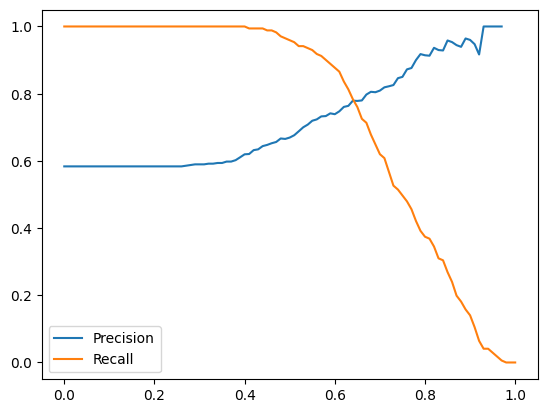

In [43]:
plt.plot(df_scores['threshold'], df_scores['Precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['Recall'], label='Recall')
plt.legend()

In [44]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

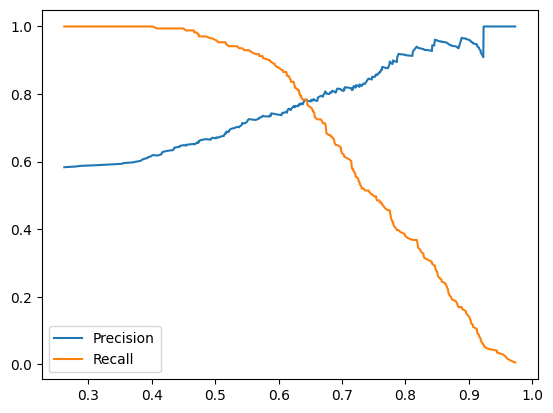

In [46]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.legend()

### Question 4
### R: 0.57

In [ ]:
def f1_score_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for i in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        t = i
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['Precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp']) # Precision
    df_scores['Recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn']) # Recall

    df_scores['f1'] = (2*df_scores['Precision']*df_scores['Recall']) / (df_scores['Precision']+df_scores['Recall']) # F1 Score

    return df_scores

In [48]:
df_f1 = f1_score_dataframe(y_val,y_pred)

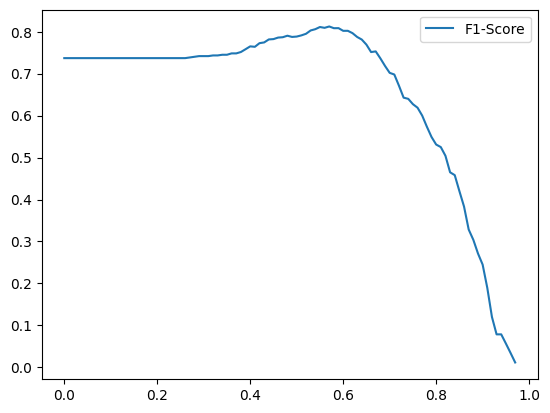

In [49]:
plt.plot(df_f1['threshold'], df_f1['f1'], label='F1-Score')
plt.legend()

In [52]:
df_f1[df_f1['f1'] == df_f1['f1'].max()]

,threshold,tp,fp,fn,tn,Precision,Recall,f1
57,0.57,156,57,15,65,0.732394,0.912281,0.8125


In [54]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_val, y_pred)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_threshold = thresholds[f1_scores.argmax()]
best_f1 = f1_scores.max()

print(f'Melhor threshold: {best_threshold:.2f}')
print(f'Melhor F1: {best_f1:.3f}')


Melhor threshold: 0.55
Melhor F1: 0.815


### Question 5
### R: 0.04

In [57]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [56]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [64]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['converted'].values
    y_val = df_val['converted'].values

    dv, model = train(df=df_train, y=y_train, C=1, max_iter=1000)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [65]:
print(f'{np.mean(scores):.3f} +- {np.std(scores):.3f}')

0.822 +- 0.036


### Question 6
### R: 0.001

In [66]:
C = [0.000001, 0.001, 1]

for i in C:

    scores = []

    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['converted'].values
        y_val = df_val['converted'].values

        dv, model = train(df=df_train, y=y_train, C=i, max_iter=1000)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C = {i} | Score = {np.mean(scores):.3f} +- {np.std(scores):.3f}')

0it [00:00, ?it/s]

C = 1e-06 | Score = 0.560 +- 0.024


0it [00:00, ?it/s]

C = 0.001 | Score = 0.867 +- 0.029


0it [00:00, ?it/s]

C = 1 | Score = 0.822 +- 0.036
